In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import numpy.linalg as la

from itertools import product

import scipy.sparse as sp

from itertools import product

import random

from math import ceil

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

In [8]:
class Wilson_Cowan_system:
    def __init__(self, N=50, A=None):
        if A is not None:
            assert A.shape[0] == A.shape[1]
            N = A.shape[0]
            self.A = A
        self.N = N
        self.E0 = np.zeros(N)
        self.I0 = np.zeros(N)
        self.params = {
            'τE': 1/8,
            'τI': 1/4,
            'aE': .8,
            'aI': .8,
            'θE': 2,
            'θI': 5,
            'cEE': 8,
            'cEI': 16,
            'cIE': 8,
            'cII': 4,
            'ν': .5
        }
        self.firing_rate = lambda x: 1/(1+np.exp(-x))
        self.external_stimulus = lambda t: np.random.random(self.N)
        
    def set_initial_excitatory(self, E):
        assert E.shape == self.E0.shape
        self.E0 = E.copy()
        
    def set_initial_inhibitory(self, I):
        assert I.shape == self.I0.shape
        self.I0 = I.copy()
        
    def set_initial(self, E, I):
        self.set_initial_excitatory(E)
        self.set_initial_inhibitory(I)
        
    def set_adjacency_matrix(self, A):
        self.A = A.copy()
        
    def add_edges_from(self, edge_list, symmetric=True):
        for a, b in edge_list:
            self.A[b, a] = 1
            if symmetric:
                self.A[a, b] = 1
                
    def update_params(self, params):
        self.params = {**self.params, **params}
                
    def set_firing_rate(self, f):
        self.firing_rate = f
        
    def set_external_stimulus(self, p):
        self.external_stimulus = p
                
    def show_network(self):
        plt.figure(figsize=(16, 12))
        plt.subplot(1, 2, 1)
        angles = np.linspace(0, 2*np.pi, self.N, endpoint=False)
        for edge in [ (a, b) for a, b in product(range(self.N), range(self.N)) if self.A[a, b]==1]:
            plt.plot(np.cos([angles[node] for node in edge]), np.sin([angles[node] for node in edge]), 'k-')
        plt.plot(np.cos(angles), np.sin(angles), 'bo', markersize=(10))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.subplot(1, 2, 2)
        plt.spy(self.A)
        plt.show()
                
    def simulate(self, t_final, t0=0, dt=1e-3):
        return Wilson_Cowan_system._simulate(t_final, t0, dt, self.N, self.E0, self.I0, 
                                             self.A,
                                             self.firing_rate,
                                             self.external_stimulus,
                                             **self.params)
            
    def _simulate(t_final, t0, Δt, N, E0, I0, A, firing_rate, external_stimulus,
                  τE, τI, aE, aI, θE, θI, cEE, cEI, cIE, cII, ν):
        steps = ceil((t_final-t0)/Δt)
        ts = np.arange(steps+1)*Δt + t0
        Es = np.zeros((steps+1, N))
        Is = np.zeros((steps+1, N))
        t = t0
        E = E0.copy()
        I = I0.copy()
        for step, t in enumerate(ts):
            Es[step], Is[step] = E, I
            E += (-Es[step] + firing_rate(aE*( cEE*Es[step] - cEI*Is[step] - θE + external_stimulus(t) + ν*A@Es[step] )))/τE * Δt
            I += (-Is[step] + firing_rate(aI*( cIE*Es[step] - cII*Is[step] - θI)))/τI * Δt
            
        return ts, Es, Is
    
def ring_edge_list(N=50, link_radius=3):
    return [(a,(a+i)%N) for a in range(N) for i in range(-link_radius, link_radius+1) if i!=0]

def randomize_edges(N, edge_list, random_edges):
    num_edges = len(edge_list)
    random.shuffle(edge_list)
    if random_edges > 0:
        edge_list = edge_list[:-random_edges]
    while len(edge_list) < num_edges:
        a, b = random.randrange(N), random.randrange(N)
        if a != b and (a, b) not in edge_list:
            edge_list.append((a,b))
    return edge_list
            
def edge_list_to_matrix(N, edge_list, matrix_type='dense'):
    if matrix_type == 'dense':
        A = np.zeros((N, N))
        for a, b in edge_list:
            A[b, a] = 1 
    elif matrix_type == 'csr':
        data = [1 for _ in edge_list]
        row_index = [b for a, b in edge_list]
        col_index = [a for a, b in edge_list]
        A = sp.csr_matrix((data, (row_index, col_index)), shape=(N,N))
        
    return A

In [24]:
# τE, τI = 0.125, 0.25 # excititory/inhibitory time constant
# aE, aI = .8, .8      # excititory/inhibitory gain
# θE, θI = 2, 5        # excititory/inhibitory threshold
# cEE = 8  # strength of excititory stimulus due to excititory population
# cEI = 16 # strength of excititory stimulus due to inhibitory population
# cIE = 8  # strength of inhibitory stimulus due to excititory population
# cII = 4  # strength of inhibitory stimulus due to inhibitory population
# ν = .8 # Network coupling strength

# firing_rate = lambda x: 1/(1+np.exp(-x))

# N = 50 

# matrix_type = 'dense'
# # matrix_type = 'csr'

# # (a, b) ==> axon of a is connected to dendrite of b
# # edge_list = [
# #     (0, 1),
# #     (1, 0)
# # ]

# # edge_list = [(a, b) for a, b in product(range(N), range(N)) if a != b]

# link_radius = 3
# edge_list = [(a,(a+i)%N) for a in range(N) for i in range(-link_radius, link_radius+1) if i!=0]

# random_edges = 20
# num_edges = len(edge_list)
# random.shuffle(edge_list)
# if random_edges > 0:
#     edge_list = edge_list[:-random_edges]
# while len(edge_list) < num_edges:
#     a, b = random.randrange(N), random.randrange(N)
#     if a != b and (a, b) not in edge_list:
#         edge_list.append((a,b))
        
# if matrix_type == 'dense':
#     A = np.zeros((N, N))
#     for a, b in edge_list:
#         A[b, a] = 1
        
# elif matrix_type == 'csr':
#     data = [1 for _ in edge_list]
#     row_index = [b for a, b in edge_list]
#     col_index = [a for a, b in edge_list]
#     A = sp.csr_matrix((data, (row_index, col_index)), shape=(N,N))

# E = np.zeros(N)
# I = np.zeros(N)


# p_all = np.ones(N)
# p_half = np.zeros(N)
# p_half[:N//2] += 1
# def external_stimulus(t):
#     ret = 0*np.random.randn(N)
#     return ret
# #     if t <= 10:
# #         pass
# #     elif 10 <= t < 20:
# #         ret += 2*p_half
# #     elif 20<= t:
# #         pass
# #     return ret
#     #return p_on * np.random.randn(N)# * p_on

# # set initial conditions
# # E[:10] = 1
# # E = np.random.random(N)

# t0, t_final = 0, 10
# Δt = 1e-2

# steps = int((t_final-t0)/Δt)

# ts = np.arange(steps+1)*Δt

# Es = np.zeros((steps+1, N))
# Is = np.zeros((steps+1, N))

# t = 0
# for step, t in enumerate(ts):
#     Es[step], Is[step] = E, I
#     E += (-Es[step] + firing_rate(aE*( cEE*Es[step] - cEI*Is[step] - θE + external_stimulus(t) + ν*A@Es[step] )))/τE * Δt
#     I += (-Is[step] + firing_rate(aI*( cIE*Es[step] - cII*Is[step] - θI)))/τI * Δt

In [69]:
N = 50
random_edges = 20 #int(N//5)
edge_list = ring_edge_list(N)
edge_list = randomize_edges(N, edge_list, random_edges)
A = edge_list_to_matrix(N, edge_list)
network = Wilson_Cowan_system(A=A)
network.params['ν'] = 40 / N

In [74]:
network = Wilson_Cowan_system(A=A)
network.params['ν'] = 40 / N
network.external_stimulus = lambda t: 0
# network.external_stimulus = lambda t: np.random.random(N)

In [75]:
ts, Es, Is = network.simulate(10)

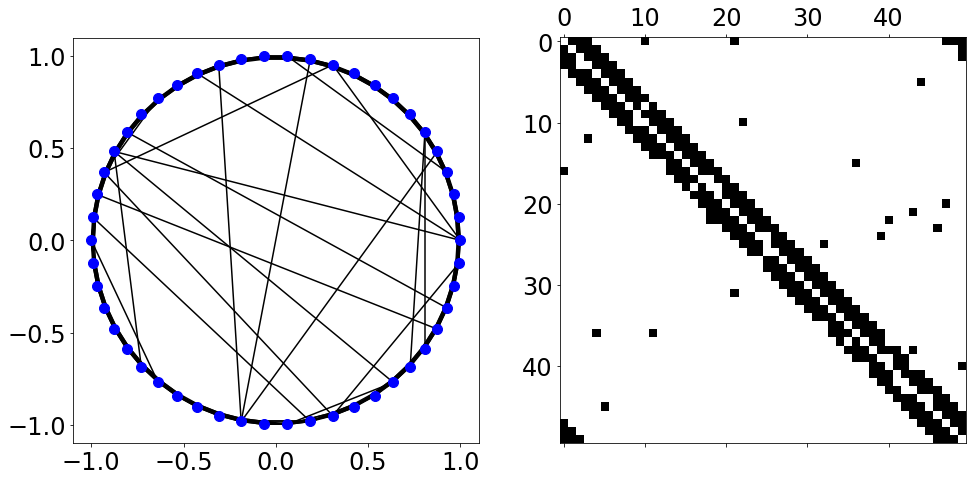

In [76]:
# plt.figure(figsize=(16, 12))
# plt.subplot(1, 2, 1)
# angles = np.linspace(0, 2*np.pi, N, endpoint=False)
# for edge in edge_list:
#     plt.plot(np.cos([angles[node] for node in edge]), np.sin([angles[node] for node in edge]), 'k-')
# plt.plot(np.cos(angles), np.sin(angles), 'bo', markersize=(10))
# plt.gca().set_aspect('equal', adjustable='box')
# plt.subplot(1, 2, 2)
# plt.spy(A)
# plt.show()
network.show_network()

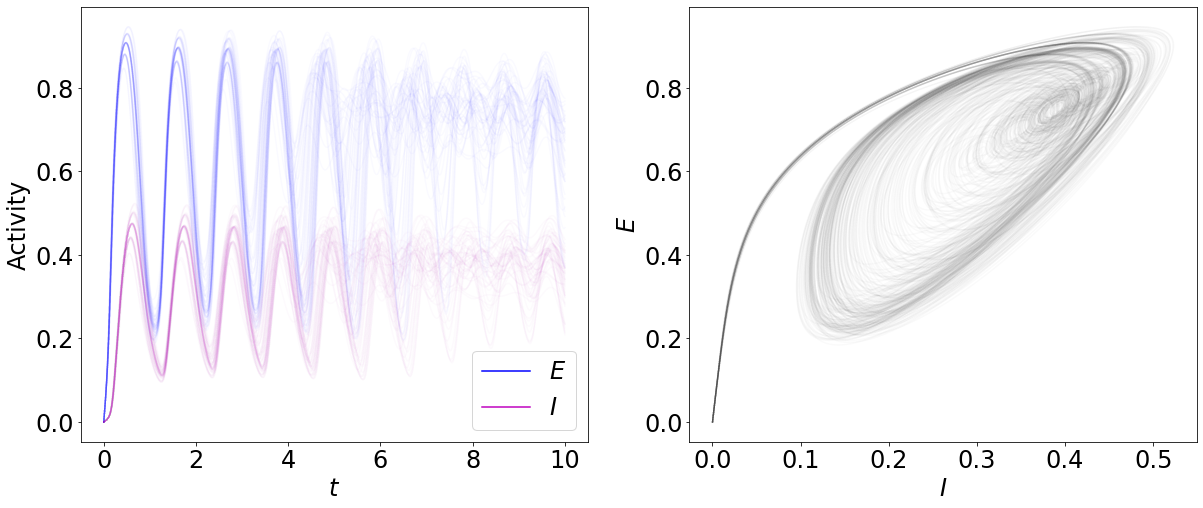

In [77]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/network.N)
plt.plot([], [], 'b-', label='$E$')
plt.plot(ts, Is, 'm-', alpha=1/network.N)
plt.plot([], [], 'm-', label='$I$')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/network.N)
plt.xlabel('$I$')
plt.ylabel('$E$')

plt.show()

In [42]:
Es.shape

(10001, 50)

In [152]:
cEE*Es[step] - cEI*Is[step] - θE + ν*A@Es[step]

array([1.84783486, 1.86631556, 2.13513311, 1.88495578, 1.91812433,
       1.57859917, 1.60820507, 1.93069919, 1.90140759, 1.87036739,
       1.43129525, 1.71318205, 1.5943417 , 1.79877961, 1.38467564,
       1.28134641, 1.198616  , 1.82806597, 1.11508046, 1.11738916,
       1.14359949, 1.16592934, 1.22698306, 1.29865489, 1.6601364 ,
       1.44470935, 1.52241437, 1.5912409 , 1.28638075, 1.69008683,
       1.71387986, 1.72292709, 1.72873428, 1.70981648, 1.68016801,
       1.64654856, 1.61592101, 1.59342442, 1.57763938, 1.57409517,
       1.90120304, 1.61498673, 1.65313237, 1.68254437, 1.72032278,
       1.75773871, 1.42976857, 1.80336065, 1.81499903, 1.82036079])

In [102]:
firing_rate(.8)

0.6899744811276125

In [13]:
-3 % 4

1